# Chess Exploration

This notebook explores possibility to use python code to analyze chess positions with AI.

In [67]:
%pip install chess openai smolagents

Note: you may need to restart the kernel to use updated packages.


Gemini 2.5 Pro Preview 05-06 (correct, sustainable)

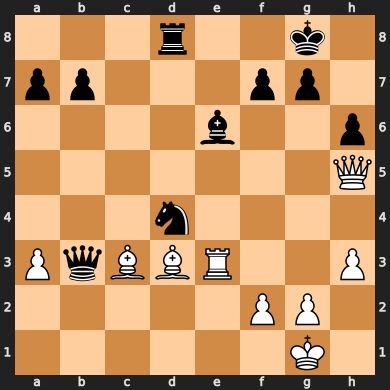

Gemini 2.5 Flash Preview 04-17 (failed)

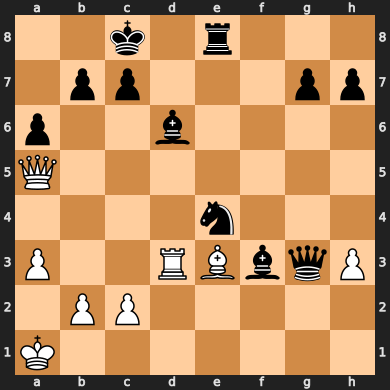

Gemini 2.0 Flash (not correct orientation)

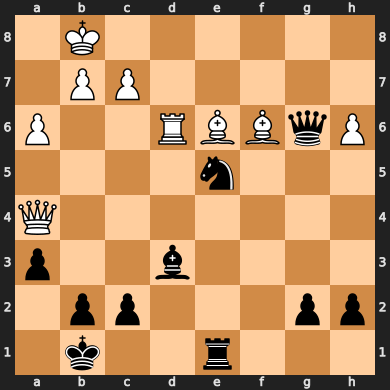

o4-mini (failed)

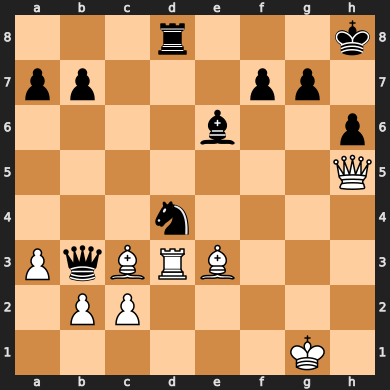

o1 (artifacts as additional pieces)

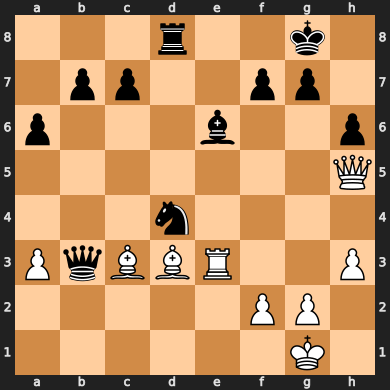

claude 3.7 with thinking (not correct orientation)

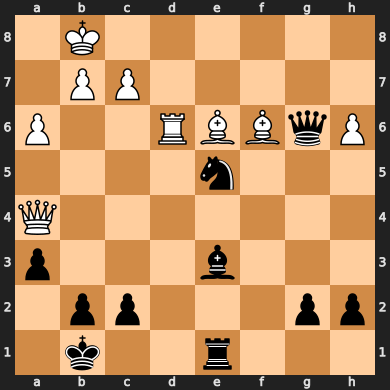

Gemini 2.0 Flash and extra prompt (not correct orientation)

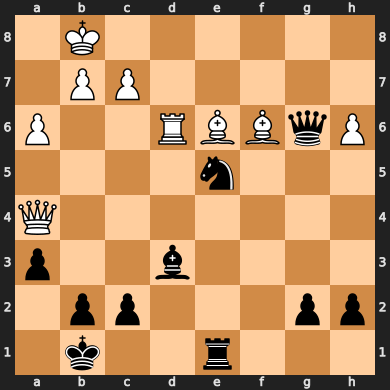

claude 3.7 with thinking and extra prompt (failed)

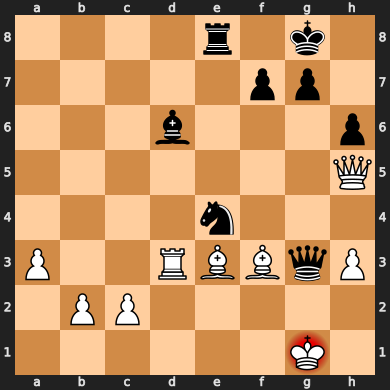

In [ ]:
import chess
from IPython.display import display, Markdown

# Describe the position of the pieces on the chessboard from the image.
# Please, nothing else but description. Use FEN notation.

# Display board starting position
board = chess.Board('3r2k1/pp3pp1/4b2p/7Q/3n4/PqBBR2P/5PP1/6K1') #gemini 2.5 Pro Preview (correct, sustainable)
display(Markdown("Gemini 2.5 Pro Preview 05-06 (correct, sustainable)"))
display(board)

board = chess.Board('2k1r3/1pp3pp/p2b4/Q7/4n3/P2RBbqP/1PP5/K7') #gemini 2.5 Flash Preview 04-17 (correct, sustainable)
display(Markdown("Gemini 2.5 Flash Preview 04-17 (failed)"))
display(board)

board = chess.Board('1K6/1PP5/P2RBBqP/4n3/Q7/p2b4/1pp3pp/1k2r3') #gemini 2.0 Flash (not correct orientation)
display(Markdown("Gemini 2.0 Flash (not correct orientation)"))
display(board)

board = chess.Board('3r3k/pp3pp1/4b2p/7Q/3n4/PqBRB3/1PP5/6K1') #o4-min
display(Markdown("o4-mini (failed)"))
display(board)

board = chess.Board('3r2k1/1pp2pp1/p3b2p/7Q/3n4/PqBBR2P/5PP1/6K1') #o1 (artifacts)
display(Markdown("o1 (artifacts as additional pieces)"))
display(board)

board = chess.Board('1K6/1PP5/P2RBBqP/4n3/Q7/p3b3/1pp3pp/1k2r3') #claude 3.7 with thinking (not correct orientation)
display(Markdown("claude 3.7 with thinking (not correct orientation)"))
display(board)

# Describe the position of the pieces on the chessboard from the image.
# Pay attention to board orientation and use markers on a board or its side as a clue.
# Please, nothing else but description. Use FEN notation.

board = chess.Board('1K6/1PP5/P2RBBqP/4n3/Q7/p2b4/1pp3pp/1k2r3') #gemini 2.0 Flash (not correct orientation)
display(Markdown("Gemini 2.0 Flash and extra prompt (not correct orientation, prompt ignored)"))
display(board)

board = chess.Board('4r1k1/5pp1/3b3p/7Q/4n3/P2RBBqP/1PP5/6K1') #claude 3.7 with thinking (failed)
display(Markdown("claude 3.7 with thinking and extra prompt (failed)"))
display(board)

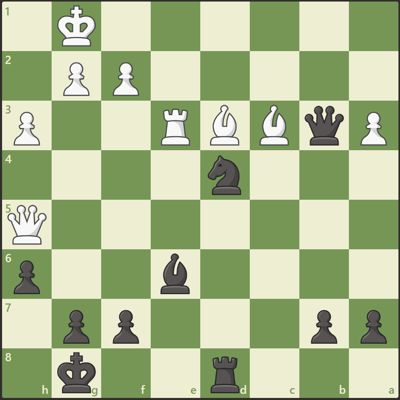

In [23]:
from PIL import Image
from IPython.display import display

CHESSBOARD_IMG_PATH = "data/tasks/cca530fc-4052-43b2-b130-b30968d8aa44/cca530fc-4052-43b2-b130-b30968d8aa44.png"

# Display board from the GAIA challenge
board_img = Image.open(CHESSBOARD_IMG_PATH)
display(board_img.resize((400, 400)))

In [ ]:
board_description_prompt="""
Describe the position of the pieces on the chessboard from the image. Please, nothing else but description.
"""

extract_positions_prompt="""
Write down all positions with known pieces.
Use a standard one-letter code to name pieces.

It is important to use the correct case for piece code. Use upper case for white and lower case for black.
It is important to include information about all the mentioned positions.

Describe each position in a new line.
Return nothing but lines with positions.
"""

White pieces:
- King on g1
- Queen on h5
- Rook on e3
- Bishop on d3
- Bishop on c3
- Pawns on f2, g2, h3, a3

Black pieces:
- King on g8
- Queen on b3
- Rook on d8
- Bishop on e6
- Knight on d4
- Pawns on f7, g7, h6, a7, b7

Kg1  
Qh5  
Re3  
Bd3  
Bc3  
Pf2  
Pg2  
Ph3  
Pa3  
kg8  
qb3  
rd8  
be6  
nd4  
pf7  
pg7  
ph6  
pa7  
pb7

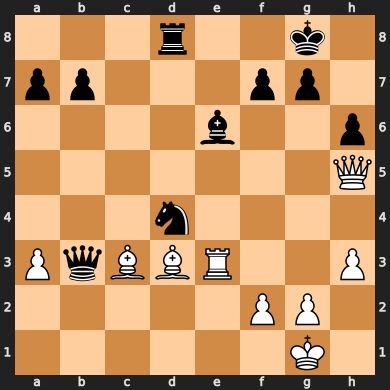

In [60]:
from openai import OpenAI
import base64

def image_to_board_fen(img_path: str, img_type: str) -> str:
    """
    Convert a chessboard image to board part of the FEN.
    Args:
        image_path (str): Path to the chessboard image.
        image_type (str): Type of the image (e.g., "image/png").
    Returns:
        str: Board part of the FEN.
    """
    client = OpenAI()

    with open(img_path, "rb") as img_f:
      img_b = img_f.read()
    response = client.responses.create(
      model="gpt-4.1",
      input=[{"role": "user", "content": [
        {"type": "input_text", "text": "Describe the position of the pieces on the chessboard from the image. Please, nothing else but description."},
        {"type": "input_image", "image_url": f"data:{img_type};base64,{base64.b64encode(img_b).decode('utf-8')}"}
      ]}]
    )
    board_desc = response.output_text
    display(Markdown(board_desc))

    response = client.responses.create(
      model="gpt-4.1",
      input=[{"role": "user", "content": [
        {"type": "input_text", "text": "Describe the position of the pieces on the chessboard from the image. Please, nothing else but description."},
      ]}] + response.output + [{"role": "user", "content": [
        {"type": "input_text", "text": """\
        Write down all positions with known pieces.
        Use a standard one-letter code to name pieces.

        It is important to use the correct case for piece code. Use upper case for white and lower case for black.
        It is important to include information about all the mentioned positions.

        Describe each position in a new line.
        Follow format: <piece><position> (piece first, than position, no spaces)
        Return nothing but lines with positions.
        """},
      ]}
      ]
    )
    board_pos = response.output_text
    display(Markdown(board_pos))
    
    pos_dict = {}
    for pos_str in board_pos.splitlines():
      pos_str = pos_str.strip()
      if len(pos_str) != 3:
        continue
      piece = pos_str[0]
      pos = pos_str[1:3]
      pos_dict[pos]=piece

    board_fen=""
    for rank in range(8, 0, -1):
      empty = 0
      for file_c in range(ord('a'), ord('h') + 1):
        file = chr(file_c)
        square = file + str(rank)
        if square in pos_dict:
          if empty > 0:
            board_fen += str(empty)
            empty = 0
          board_fen += pos_dict[square]
        else:
          empty += 1
      if empty > 0:
        board_fen += str(empty)
      if rank != 1:
        board_fen += "/"
    
    return board_fen

fen = image_to_board_fen(CHESSBOARD_IMG_PATH, "image/png")
board = chess.Board(fen)
display(board)

In [ ]:
original_board = board.copy() # Qd1+ Re1 Qxe1+ Bxe1        
print(board.fen())

3r2k1/pp3pp1/4b2p/7Q/3n4/PqBBR2P/5PP1/6K1 b - - 0 1


In [123]:
from smolagents import CodeAgent, LiteLLMModel, OpenAIServerModel, Tool, tool
import requests
from urllib.parse import urljoin
import shutil

from dotenv import load_dotenv
load_dotenv()

class GetAttachmentTool(Tool):
    name = "get_attachment"
    description = """Retrieves attachment for current task in data url format."""
    inputs = {
      "allow_url": {
        "type": "boolean",
        "description": "Return public URL if available. Use true if agent can download the file or false otherwise to receive data URL or text directly.",
        "nullable": True,
        "default": False,
      }
    }
    output_type = "string"

    def __init__(self, agent_evaluation_api: str|None = None, task_id: str|None = None, **kwargs):
        self.agent_evaluation_api = agent_evaluation_api if agent_evaluation_api is not None else "https://agents-course-unit4-scoring.hf.space/"
        self.task_id = task_id
        super().__init__(**kwargs)
    
    def attachment_for(self, task_id: str | None):
        self.task_id = task_id

    def forward(self, allow_url: bool = False) -> str:
      if not self.task_id:
          return ""
      
      file_url = urljoin(self.agent_evaluation_api, f"files/{self.task_id}")
      if allow_url:
         return file_url
      
      response = requests.get(
        file_url,
        headers={
            "Content-Type": "application/json",
            "Accept": "application/json",
        }
      )
      response.raise_for_status()
      mime = response.headers.get("content-type", "text/plain")
      if mime.startswith("text/"):
          return response.content
      else:
          return f"data:{mime};base64,{base64.b64encode(response.content).decode('utf-8')}"


class ImageToBoardFEN(Tool):
    name = "image_to_board_fen"
    description = """Convert a chessboard image to board part of the FEN."""
    inputs = {
      "image_url": {
        "type": "string",
        "description": "Public URL of the image (preferred) or base64 encoded image in data URL format.",
      }
    }
    output_type = "string"

    def __init__(self, client: OpenAI | None = None, **kwargs):
        self.client = client if client is not None else OpenAI()
        super().__init__(**kwargs)
        
    
    def attachment_for(self, task_id: str | None):
        self.task_id = task_id

    def forward(self, image_url: str) -> str:
      """
      Convert a chessboard image to board part of the FEN.
      Args:
          image_url (str): Public URL of the image (preferred) or base64 encoded image in data URL format.
      Returns:
          str: Board part of the FEN.
      """
      client = self.client

      response = client.responses.create(
        model="gpt-4.1",
        input=[{"role": "user", "content": [
          {"type": "input_text", "text": "Describe the position of the pieces on the chessboard from the image. Please, nothing else but description."},
          {"type": "input_image", "image_url": image_url}
        ]}]
      )

      response = client.responses.create(
        model="gpt-4.1",
        input=[{"role": "user", "content": [
          {"type": "input_text", "text": "Describe the position of the pieces on the chessboard from the image. Please, nothing else but description."},
        ]}] + response.output + [{"role": "user", "content": [
          {"type": "input_text", "text": """\
          Write down all positions with known pieces.
          Use a standard one-letter code to name pieces.

          It is important to use the correct case for piece code. Use upper case for white and lower case for black.
          It is important to include information about all the mentioned positions.

          Describe each position in a new line.
          Follow format: <piece><position> (piece first, than position, no spaces)
          Return nothing but lines with positions.
          """},
        ]}
        ]
      )
      board_pos = response.output_text
      
      pos_dict = {}
      for pos_str in board_pos.splitlines():
        pos_str = pos_str.strip()
        if len(pos_str) != 3:
          continue
        piece = pos_str[0]
        pos = pos_str[1:3]
        pos_dict[pos]=piece

      board_fen=""
      for rank in range(8, 0, -1):
        empty = 0
        for file_c in range(ord('a'), ord('h') + 1):
          file = chr(file_c)
          square = file + str(rank)
          if square in pos_dict:
            if empty > 0:
              board_fen += str(empty)
              empty = 0
            board_fen += pos_dict[square]
          else:
            empty += 1
        if empty > 0:
          board_fen += str(empty)
        if rank != 1:
          board_fen += "/"
        
      return board_fen

@tool
def get_chess_engine_path() -> str | None:
  """
  Get the path to the chess engine binary and can be used with chess.engine.SimpleEngine.popen_uci function.
  Returns:
      str: Path to the chess engine.
  """
  path = shutil.which("stockfish")
  return path if path else None

# model = LiteLLMModel(model_id="claude-3-7-sonnet-latest")
model = OpenAIServerModel(model_id="gpt-4.1")
agent = CodeAgent(
  name="chess_player",
  description="Chess grandmaster empowered by chess engine. Always thinks at least 100 steps ahead.",
  tools=[
    GetAttachmentTool(task_id="cca530fc-4052-43b2-b130-b30968d8aa44"),
    ImageToBoardFEN(client=model.client),
    get_chess_engine_path,
  ],
  additional_authorized_imports=[
     "chess",
     "chess.engine",
  ],
  model=model,
  verbosity_level=2,
)

response = agent.run("Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.")
print(response)

╭──────────────────────────────────────────── New run - chess_player ─────────────────────────────────────────────╮
│                                                                                                                 │
│ Review the chess position provided in the image. It is black's turn. Provide the correct next move for black    │
│ which guarantees a win. Please provide your response in algebraic notation.                                     │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4.1 ───────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: I need to analyze the given chess position from the image to find the best move for Black. First, I'll    
retrieve the image attachment. Then, I'll convert the image to a FEN string using the appropriate tool. After that,
I will analyze the position to determine Black's best move.                                                        
                                                                                                                   
Code:                                                                                                              
```py                                                                                                              
# Step 1: Retrieve the image attachment as a data URL                                                              
image_data_url = get_attachment(allow_url=True)                                                                    
print(image_data_url)                                                                                              
```<end_code>                                                                                                      

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Step 1: Retrieve the image attachment as a data URL                                                            
  image_data_url = get_attachment(allow_url=True)                                                                  
  print(image_data_url)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
https://agents-course-unit4-scoring.hf.space/files/cca530fc-4052-43b2-b130-b30968d8aa44

Out: None

[Step 1: Duration 2.93 seconds| Input tokens: 2,131 | Output tokens: 96]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: It appears the image data URL was not output directly, possibly due to being too large or redirected to   
logs. I will check if a direct URL or data URI was returned, and then use the `image_to_board_fen` tool to convert 
the image to a FEN string for chess analysis.                                                                      
                                                                                                                   
Code:                                                                                                              
```py                                                                                                              
# Let's try to pass the presumed image URL (that should be available) to the FEN conversion tool.                  
# Since the output mentions logs are at a provided URL, I'll try using that as the image source.                   
                                                                                                                   
image_url = "https://agents-course-unit4-scoring.hf.space/files/cca530fc-4052-43b2-b130-b30968d8aa44"              
fen = image_to_board_fen(image_url=image_url)                                                                      
print(fen)                                                                                                         
```<end_code>                                                                                                      

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Let's try to pass the presumed image URL (that should be available) to the FEN conversion tool.                
  # Since the output mentions logs are at a provided URL, I'll try using that as the image source.                 
                                                                                                                   
  image_url = "https://agents-course-unit4-scoring.hf.space/files/cca530fc-4052-43b2-b130-b30968d8aa44"            
  fen = image_to_board_fen(image_url=image_url)                                                                    
  print(fen)                                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
3r2k1/pp3pp1/4b2p/7Q/3n4/PqBBR2P/5PP1/6K1

Out: None

[Step 2: Duration 16.70 seconds| Input tokens: 4,480 | Output tokens: 260]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: I have obtained the FEN of the current board: `3r2k1/pp3pp1/4b2p/7Q/3n4/PqBBR2P/5PP1/6K1`. It's Black's   
turn. I will use python and the chess engine to analyze this position and determine the best move for Black that   
guarantees a win.                                                                                                  
                                                                                                                   
Code:                                                                                                              
```py                                                                                                              
import chess                                                                                                       
import chess.engine                                                                                                
                                                                                                                   
# Set up the position from the FEN                                                                                 
board = chess.Board("3r2k1/pp3pp1/4b2p/7Q/3n4/PqBBR2P/5PP1/6K1 b - - 0 1")                                         
                                                                                                                   
# Get the chess engine path                                                                                        
engine_path = get_chess_engine_path()                                                                              
engine = chess.engine.SimpleEngine.popen_uci(engine_path)                                                          
                                                                                                                   
# Analyze the best move for Black                                                                                  
info = engine.analyse(board, chess.engine.Limit(time=1.5))                                                         
best_move = info["pv"][0]                                                                                          
algebraic_move = board.san(best_move)                                                                              
                                                                                                                   
engine.quit()                                                                                                      
final_answer(algebraic_move)                                                                                       
```<end_code>                                                                                                      

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import chess                                                                                                     
  import chess.engine                                                                                              
                                                                                                                   
  # Set up the position from the FEN                                                                               
  board = chess.Board("3r2k1/pp3pp1/4b2p/7Q/3n4/PqBBR2P/5PP1/6K1 b - - 0 1")                                       
                                                                                                                   
  # Get the chess engine path                                                                                      
  engine_path = get_chess_engine_path()                                                                            
  engine = chess.engine.SimpleEngine.popen_uci(engine_path)                                                        
                                                                                                                   
  # Analyze the best move for Black                                                                                
  info = engine.analyse(board, chess.engine.Limit(time=1.5))                                                       
  best_move = info["pv"][0]                                                                                        
  algebraic_move = board.san(best_move)                                                                            
                                                                                                                   
  engine.quit()                                                                                                    
  final_answer(algebraic_move)                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Rd5

[Step 3: Duration 7.34 seconds| Input tokens: 7,193 | Output tokens: 496]

Rd5
